In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal

from include.coordinates import to_utm, utm_distance
from include.rotation import  get_azimuth, reorientation

In [3]:
# change pyplot style
plt.style.use('bmh')

In [4]:
def sma_filter(l, w=25):
	return np.convolve(l, np.ones((w,))/w, mode='valid')

def median_filter(l, w=51):
	return scipy.signal.medfilt(l, w)

def pm_180(l):
	""" Change range from [0,360) to [-180,180] """
	return np.array([ v if v<=180 else v-360 for v in l ])

In [5]:
# read sensor data from a smartphone with the Y axis 
# rotated 90º CCW with respect to the the vehicle's
data = pd.read_csv('data.csv.gz')

In [6]:
easting, northing, znumber, zletter = to_utm(
	data['latitude' ][::50].values,  # GPS reports one sample per second
	data['longitude'][::50].values
)

distance = utm_distance(easting, northing)

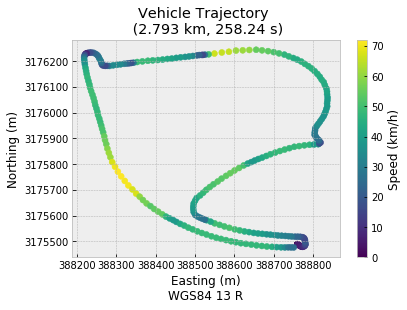

In [7]:
sc = plt.scatter(
	easting, 
	northing, 
	c=data['speed'][::50] *3.6 # convert speed from m/s to km/h, one sample per second
)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Speed (km/h)', rotation=90)
plt.title('Vehicle Trajectory \n (%.3f km, %.2f s)'%(distance/1000.0, len(data['latitude' ])/50.0) )
plt.ylabel('Northing (m)')
plt.xlabel('Easting (m)\n' + 'WGS84' +' '+ str(znumber) +' '+ zletter)
plt.show()

In [8]:
# calculate azimuth from accelerometer and magnetomer readings, considering magnetic declination
azimuth = get_azimuth(
	data['acc_x'], data['acc_y'], data['acc_z'], 
	data['mag_x'], data['mag_y'], data['mag_z'], 
	data['declination']
)
azimuth = median_filter(azimuth)

bearing = median_filter( data['bearing'])
bearing = pm_180(bearing)

# yaw is estimated as the difference between GPS reported direction of travel and azimuth
yaw = bearing - azimuth 
yaw = pm_180(yaw)
median_yaw = np.median(yaw)

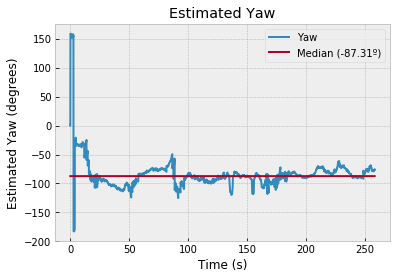

In [9]:
t = np.linspace(0, len(azimuth)/50.0, len(azimuth))

plt.title('Estimated Yaw')
plt.plot( t, yaw, label='Yaw')
plt.plot( t, [median_yaw]*len(azimuth), label='Median (%.2fº)'%(median_yaw) )
plt.ylabel('Estimated Yaw (degrees)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [10]:
r = reorientation(data['acc_x'], data['acc_y'], data['acc_z'], np.radians(median_yaw) )

acc_x = sma_filter(r[:,0])
acc_y = sma_filter(r[:,1])
acc_z = sma_filter(r[:,2])
speed = sma_filter(data['speed'])

t = np.linspace(0, len(acc_x)/50.0, len(acc_x))

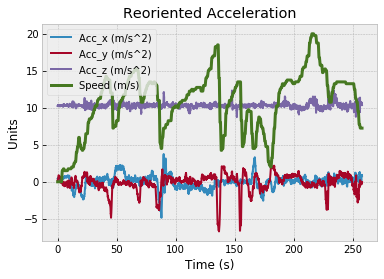

In [11]:
plt.title('Reoriented Acceleration')
plt.plot(t, acc_x, label='Acc_x (m/s^2)')
plt.plot(t, acc_y, label='Acc_y (m/s^2)')
plt.plot(t, acc_z, label='Acc_z (m/s^2)')
plt.plot(t, speed, label='Speed (m/s)', linewidth=3)
plt.xlabel('Time (s)')
plt.ylabel('Units')
plt.legend(loc='upper left')
plt.show()